# Hypothesis Testing - Supermarket Sales

Project focused on exploring business insights emphasizing statistical tests.
 
Margin of error set in 5%.

Importing libraries, data and checking for consistency

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  pingouin import anova, chi2_independence
from scipy.stats import probplot , mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

df = pd.read_csv(r".\supermarket_sales.csv")
print(df.shape)
display(df.head())
print(df.dtypes)
print(df.isna().sum())


(1000, 17)


,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


Invoice ID                  object
Branch                      object
City                        object
Customer type               object
Gender                      object
Product line                object
Unit price                 float64
Quantity                     int64
Tax 5%                     float64
Total                      float64
Date                        object
Time                        object
Payment                     object
cogs                       float64
gross margin percentage    float64
gross income               float64
Rating                     float64
dtype: object
Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Date                       0
Time                       0
Payment                    0
cogs          

### Do total purchasing vary based on gender?
After performing EDA, I notice that "Total" distribution is right skewed, and no normally distribution assumptions can be made.  

#### EDA



Text(0.5, 1.0, 'QQ Plot - Normality test')

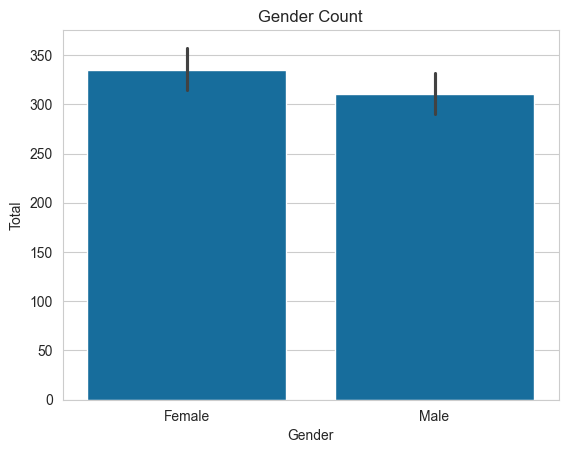

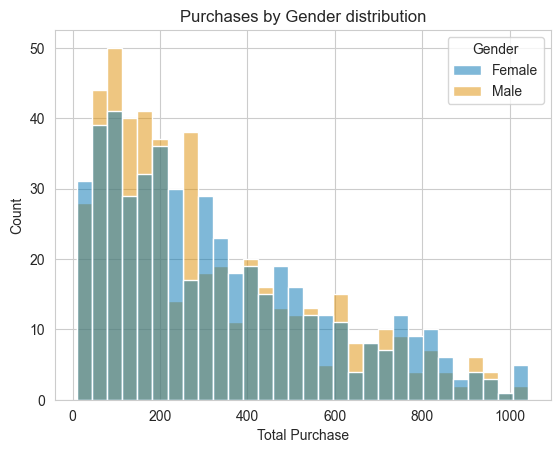

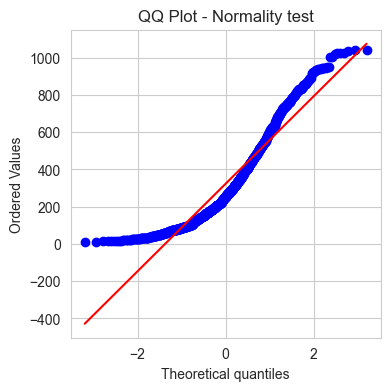

In [2]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")
sns.barplot(data= df, x= "Gender", y="Total")
plt.xlabel("Gender")
plt.title("Gender Count")

fig1, ax1 = plt.subplots()
sns.histplot(df, x="Total", hue="Gender", bins= 30)
plt.ylabel("Count")
plt.xlabel("Total Purchase")
plt.title("Purchases by Gender distribution")

fig2, ax2=plt.subplots(figsize=(4,4))
probplot(df["Total"], dist="norm", plot=plt)
plt.title("QQ Plot - Normality test")

#### Mann Whitney U test
Due to distribution, we cannot perform a 2 sample t test. Therefore I make a non-parametric test, Mann Whitney U, with the following hypothesis:

H0: Distributions of both groups are equal.  
H1: Groups have different distributions


In [3]:
display(mannwhitneyu(df[df["Gender"]=="Female"]["Total"], df[df["Gender"]=="Male"]["Total"], alternative='greater'))

MannwhitneyuResult(statistic=132497.5, pvalue=0.05031546124568771)

#### Conclusion
P-value (0.0503) is slightly above the predetermined margin of error of 5%.  
 
Therefore we cannot reject the null hypothesis, and we conclude that there is not enough statistical evidence to support the claim that there is a difference in the total purchases by gender.


### Bootstrap Distribution of means
As I'm dealing with a non-normal distribution, I'll perform a Bootstrap Distribution in order to estimate mean of total purchases by gender, and provide a 95% confidence interval.  

_A random seed was provided for reproducibility_

In [4]:
mean_women_total = []
mean_men_total = []
np.random.seed(5)

for i in range(1000):
    df_bootstrap = df[["Gender","Total"]].sample(frac=1, replace=True, random_state= np.random.choice(1000, 1000))
    mean_women_total.append(df_bootstrap[df_bootstrap["Gender"]=='Female']["Total"].mean())
    mean_men_total.append(df_bootstrap[df_bootstrap["Gender"]=='Male']["Total"].mean())

print("Bootstrap mean for women's purchases: {}\n95% Confidence Interval {}".format(np.round(np.mean(mean_women_total),2), np.round(np.percentile(mean_women_total, [2.5, 97.5]),2)))
print("Bootstrap mean for men's purchases: {}\n95% Confidence Interval {}".format(np.round(np.mean(mean_men_total),2), np.round(np.percentile(mean_men_total, [2.5, 97.5]),2)))


Bootstrap mean for women's purchases: 334.55
95% Confidence Interval [312.66 356.89]
Bootstrap mean for men's purchases: 310.08
95% Confidence Interval [288.52 331.89]


### Is mean Rating different across different Cities?

#### Checking assumptions for ANOVA test:
* Dependent variable is approximately normally distributed within each group.
* Homoscedasticity: the variance of the dependent variable is approximately the same across all groups.


City
Mandalay     2.936833
Naypyitaw    2.905408
Yangon       2.997555
Name: value, dtype: float64


Text(0.5, 1.0, 'KDE: Rating by City')

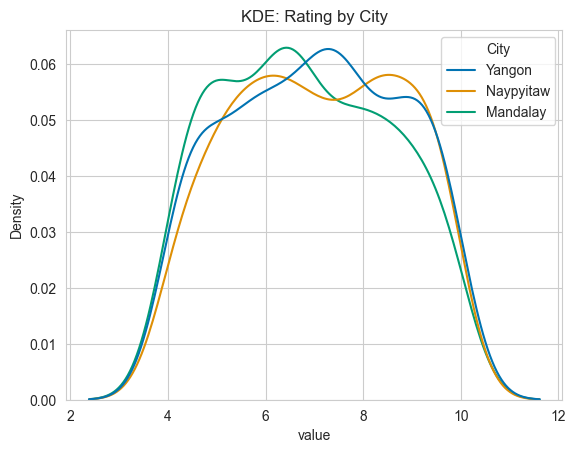

In [5]:
df_melt = df.melt(id_vars="City", value_vars="Rating")
print(df_melt.groupby("City")["value"].var())
sns.kdeplot(data= df_melt, x="value", hue="City")
plt.title("KDE: Rating by City")

### ANOVA test 

After checking assumptions, we are able to perform an ANOVA test under the following hypothesis:

H0: The mean rating is the same across all cities.  
H1: At least one city mean rating is different from the others.  

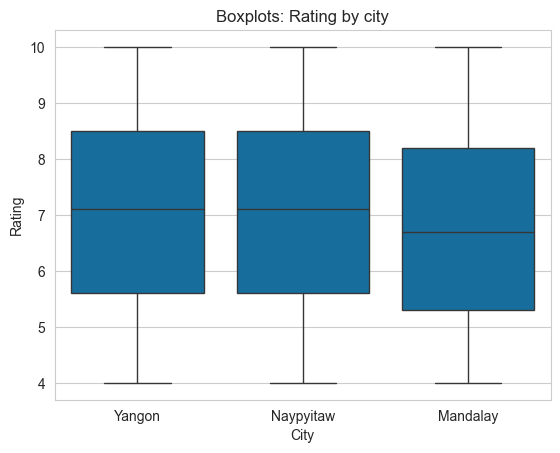

,Source,ddof1,ddof2,F,p-unc,np2
0,City,2,997,2.075477,0.126038,0.004146


In [6]:
sns.boxplot(data=df, y="Rating", x= "City")
plt.title("Boxplots: Rating by city")
plt.show()
anova(data = df, dv="Rating", between="City")

#### Test Conclusion

We fail to reject the null hypothesis with a p-value of 0.126. This suggests that we do not have enough evidence to conclude that the mean rating differs across all cities, and any observed differences may be due to random chance.

### Are Customer type and Product Line independent?

#### Chi-square Independence Test

I perform an Independence Test in order to evualate significance association between these 2 categorical variables. 
 
H0: There is no significant association between the Customer Type and Product Line.  
H1: There is significant association between these 2 variables.  

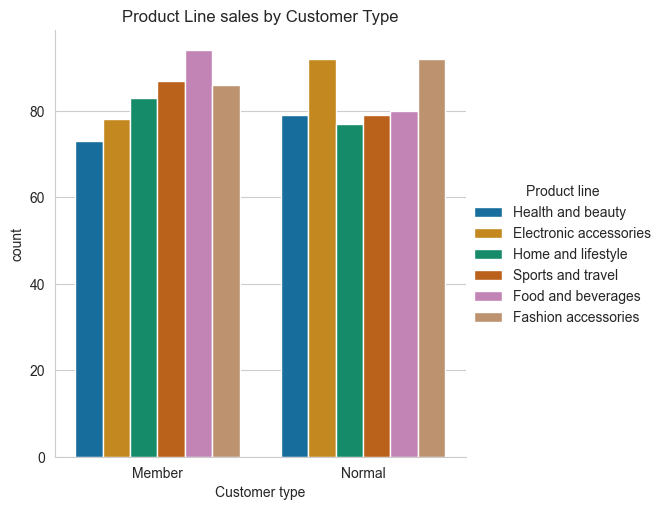

Observed frequencies:


Product line,Electronic accessories,Fashion accessories,Food and beverages,Health and beauty,Home and lifestyle,Sports and travel
Customer type,,,,,,
Member,78,86,94,73,83,87
Normal,92,92,80,79,77,79


,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,3.325023,5.0,0.650013,0.057663,0.244579
1,cressie-read,0.666667,3.325646,5.0,0.649918,0.057668,0.244622
2,log-likelihood,0.000000,3.327837,5.0,0.649583,0.057687,0.244773
3,freeman-tukey,-0.500000,3.330310,5.0,0.649205,0.057709,0.244943
4,mod-log-likelihood,-1.000000,3.333497,5.0,0.648717,0.057736,0.245163
5,neyman,-2.000000,3.342023,5.0,0.647414,0.057810,0.245752


In [7]:
sns.catplot(x="Customer type", hue="Product line", data=df, kind="count")
plt.title("Product Line sales by Customer Type", fontsize="large")
plt.show()
expected, observed, stats = chi2_independence(data=df, x="Customer type", y="Product line")
print("Observed frequencies:")
display(observed)
display(stats)

#### Test Conclusion
We fail to reject the null hypothesis with a small statistic and high p-value. We are able to assume that Customer Type and Product Line are independent.

## 

### Is the proportion of "Members" equal in women and men?

#### 2 Sample Proportion Test

In order to analyze this topic I've run a 2 sample proportion test with the following hypothesis:  
 
H0: There is no significant difference in proportion of Members by gender.  
H1: The proportions of Members are differente for each gender.  

In [8]:
df_group = df.groupby("Gender")['Customer type'].value_counts()
count = np.array(df_group.xs('Member', level='Customer type'))
nobs = np.array(df_group.groupby("Gender").sum())
z_score, p_value = proportions_ztest(count, nobs, alternative = 'two-sided')

display(df_group)
print(z_score, p_value)

Gender  Customer type
Female  Member           261
        Normal           240
Male    Normal           259
        Member           240
Name: count, dtype: int64

1.264789632119474 0.2059467489642267


#### Test Conclusion
Considering a p-value of 0.206, we fail to reject the null hypothesis and consider that there is no significant difference between the proportions of Members in the two groups.

### Final Comments

This project illustrated how exploratory data analysis (EDA) and statistical hypothesis testing can address specific business requirements.
 
The insights gained from these analyses pave the way for further investigation and potential development of machine learning algorithms tailored to meet the specific needs of the business.  

The results obtained here provide a foundation for informed decision-making and continuous improvement in line with business objectives.





